# Basic Training Scheme development notebook

## Importing section

In [1]:
import torch
from torch import optim, nn
from torch.utils.data import random_split, DataLoader
from etnn.data.ferris_wheel import load_pure_ferris_wheel_dataset
from etnn.data.tree_structure import TreeNode
from etnn.nn.layer_framework import ChiralLayerManagementFramework
from tqdm import tqdm
import matplotlib.pyplot as plt
from etnn.tools.training import train_epoch, eval_epoch

In [2]:
import numpy as np

## Parameter definition

In [3]:
NUM_GONDOLAS = 10
NUM_PART_PG = 5
DATASET_SIZE = 10_000
DATASET_PATH = "../datasets"

In [4]:
val_perc = 0.1
test_perc = 0.2
BATCH_SIZE = 32

In [5]:
INPUT_DIM = 15
HIDDEN_DIM = 32
OUT_DIM = 1
K=2
LEARNING_RATE = 0.001
NUM_MAX_EPOCHS = 10

## data preparation

In [6]:
dataset = load_pure_ferris_wheel_dataset(
    num_gondolas=NUM_GONDOLAS,
    num_part_pg=NUM_PART_PG,
    num_to_generate=DATASET_SIZE,
    dataset_path=DATASET_PATH
)

In [7]:
len(dataset)

10000

In [8]:
generator = torch.Generator().manual_seed(420)
train_ds, val_ds, test_ds = random_split(
    dataset,
    [1-val_perc-test_perc, val_perc, test_perc],
    generator=generator
)

In [9]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
# todo: add more tree mutated sequences that are in dataset
# todo: add some faulty sequences which disturb this and see how much this affects the training

## Build tree structure

In [11]:
tree_structure = TreeNode(
    node_type="C",
    children=[
        TreeNode("P", [TreeNode("E", NUM_PART_PG)])
        for _ in range(NUM_GONDOLAS)
    ]
)

## Define device

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
device

'cuda'

## Define Model

In [14]:
model = ChiralLayerManagementFramework(
    in_dim=15,
    tree=tree_structure,
    hidden_dim=HIDDEN_DIM,
    out_dim=OUT_DIM,
    k=K
).to(device)

## Define Loss and Optimizers

In [15]:
criterion = nn.MSELoss()

In [16]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

## Training

In [17]:
# init loss history
loss_history_train = []
loss_history_test = []

In [18]:
# train for N epochs
for epoch in tqdm(range(NUM_MAX_EPOCHS)):
    mean_train_loss = train_epoch(
        model,
        train_loader,
        optimizer,
        device,
        criterion
    )

    loss_history_train += [mean_train_loss]

    loss_history_test += [eval_epoch(
        model,
        test_loader,
        device,
        criterion
    )]

100%|██████████| 10/10 [01:10<00:00,  7.08s/it]


In [19]:
loss_history_train

[tensor(1797.6412),
 tensor(39.9902),
 tensor(40.8556),
 tensor(40.8530),
 tensor(41.0737),
 tensor(43.4740),
 tensor(43.4129),
 tensor(41.9214),
 tensor(41.0723),
 tensor(39.5914)]

In [20]:
loss_history_test

[tensor(37.6660),
 tensor(42.7938),
 tensor(39.1268),
 tensor(44.9701),
 tensor(39.8503),
 tensor(56.0434),
 tensor(46.3857),
 tensor(37.1917),
 tensor(35.6188),
 tensor(36.9620)]

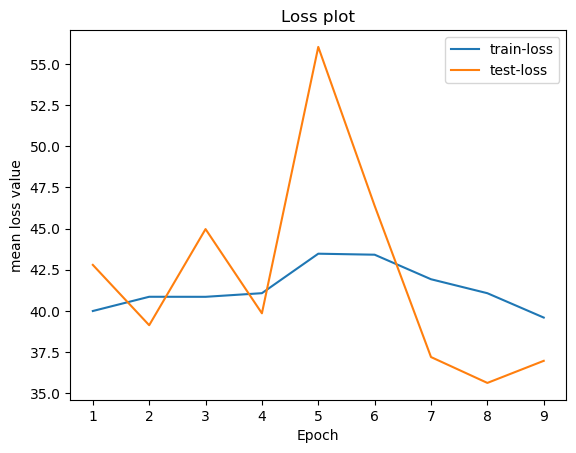

In [21]:
plt.figure()
idx = np.arange(len(loss_history_train))
offset = 1
plt.plot(idx[offset:], loss_history_train[offset:], label="train-loss")
plt.plot(idx[offset:], loss_history_test[offset:], label="test-loss")
plt.title("Loss plot")
plt.xlabel("Epoch")
plt.ylabel("mean loss value")
plt.legend()
plt.show()

## Test/Debug

for x,y in train_loader:
    break

x.shape

x

y.shape

y

for i in range(1000):
    optimizer.zero_grad()
    prediction = model(x).flatten()
    loss = criterion(prediction, y)
    print(f"Epoch:{i+1} - loss:{loss}")
    loss.backward()
    optimizer.step()

y

model(x).flatten()